In [21]:
import pandas as pd
import numpy as np
import datetime
from sklearn.impute import KNNImputer
import statsmodels.api as sm

from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import random
from scalecast.Forecaster import Forecaster
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import TimeSeriesSplit
from tqdm.notebook import tqdm as log_progress
from scalecast import GridGenerator
from statsmodels.tsa.seasonal import seasonal_decompose
from scalecast.SeriesTransformer import SeriesTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

In [22]:
## import the cleaned dataset
file_path = "/Users/justinfarnan_hakkoda/capstone_project/Capstone_Project/Cleaned_Data/cleaned_crypto_Justin.csv"
df = pd.read_csv(file_path)
df.head()

,time,product_id,low,close,volume,volatility,pct_change,day_of_week,day_name,volume_lag_1,...,momentum_30d,RSI_14,ds,y,is_weekend,y_lag_1,y_lag_3,y_lag_7,rolling_mean_7,rolling_std_7
0,2021-07-16,UNI-USD,15.9297,16.34490,5.165473e+05,10.427692,-0.014463,4,Thursday,5.165473e+05,...,0.852535,75.162273,2021-07-16,-0.014463,0,0.017797,-0.005469,0.001366,0.005224,0.016325
1,2021-07-16,BTC-USD,31025.4200,31388.06000,1.000648e+04,3.976546,0.004647,4,Thursday,1.000648e+04,...,0.497846,88.523435,2021-07-16,0.004647,0,-0.014463,-0.011218,0.030036,0.001597,0.012190
2,2021-07-17,ETH-USD,1847.0000,1899.75000,1.137243e+05,3.898213,0.012002,5,Friday,1.842217e+05,...,0.763741,88.586851,2021-07-17,0.012002,1,0.004647,0.017797,0.012002,0.001597,0.012190
3,2021-07-17,LINK-USD,15.0000,15.35974,1.919231e+06,4.555733,0.007881,5,Friday,2.246281e+06,...,0.832218,78.511587,2021-07-17,0.007881,1,0.012002,-0.014463,0.007881,0.001597,0.012190
4,2021-07-17,MATIC-USD,0.7832,0.80210,3.840267e+07,4.928498,-0.011218,5,Friday,4.884192e+07,...,0.808679,72.820229,2021-07-17,-0.011218,1,0.007881,0.004647,-0.005469,0.000775,0.012917


In [69]:
# # remove the unamed column and the day_of_week column
# df = df.drop(columns = ['Unnamed: 0', 'day_name'])
# df.head()

In [23]:
# set the time column as the index then scale the float values
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df.head()


,product_id,low,close,volume,volatility,pct_change,day_of_week,day_name,volume_lag_1,volume_lag_3,...,momentum_30d,RSI_14,ds,y,is_weekend,y_lag_1,y_lag_3,y_lag_7,rolling_mean_7,rolling_std_7
time,,,,,,,,,,,,,,,,,,,,,
2021-07-16,UNI-USD,15.9297,16.34490,5.165473e+05,10.427692,-0.014463,4,Thursday,5.165473e+05,5.165473e+05,...,0.852535,75.162273,2021-07-16,-0.014463,0,0.017797,-0.005469,0.001366,0.005224,0.016325
2021-07-16,BTC-USD,31025.4200,31388.06000,1.000648e+04,3.976546,0.004647,4,Thursday,1.000648e+04,1.000648e+04,...,0.497846,88.523435,2021-07-16,0.004647,0,-0.014463,-0.011218,0.030036,0.001597,0.012190
2021-07-17,ETH-USD,1847.0000,1899.75000,1.137243e+05,3.898213,0.012002,5,Friday,1.842217e+05,1.842217e+05,...,0.763741,88.586851,2021-07-17,0.012002,1,0.004647,0.017797,0.012002,0.001597,0.012190
2021-07-17,LINK-USD,15.0000,15.35974,1.919231e+06,4.555733,0.007881,5,Friday,2.246281e+06,2.246281e+06,...,0.832218,78.511587,2021-07-17,0.007881,1,0.012002,-0.014463,0.007881,0.001597,0.012190
2021-07-17,MATIC-USD,0.7832,0.80210,3.840267e+07,4.928498,-0.011218,5,Friday,4.884192e+07,4.884192e+07,...,0.808679,72.820229,2021-07-17,-0.011218,1,0.007881,0.004647,-0.005469,0.000775,0.012917


In [6]:
df.columns

Index(['product_id', 'low', 'close', 'volume', 'volatility', 'pct_change',
       'day_of_week', 'volume_lag_1', 'volume_lag_3', 'volume_lag_7', 'RSI',
       'MACD', 'Signal_Line', 'volatility_7d', 'volatility_14d',
       'volatility_30d', 'momentum_1d', 'momentum_7d', 'momentum_30d',
       'RSI_14', 'pct_change_lag_1', 'pct_change_lag_3', 'pct_change_lag_7'],
      dtype='object')

In [7]:
def plot_test_export_summaries(f):
    """ exports the relevant statisitcal information and displays a plot of the test-set results for the last model run
    """
    f.plot_test_set(models=f.estimator,ci=True)
    plt.title(f'{f.estimator} test-set results',size=16)
    plt.show()
    return f.export('model_summaries',determine_best_by='TestSetMAPE')[
        [
            'ModelNickname',
            'HyperParams',
            'TestSetMAPE',
            'TestSetR2',
            'InSampleMAPE',
            'InSampleR2'
        ]
    ]

In [8]:
# 'day_of_week', 'volume_lag_1', 'volume_lag_3', 'volume_lag_7',
    # 'RSI', 'MACD', 'volatility_7d', 'volatility_30d', 'momentum_7d',  'pct_change_lag_1', 'pct_change_lag_3', 'pct_change_lag_7'

In [9]:
# x_columns = [
#      'day_of_week', 'volume_lag_1', 'volume_lag_3', 'volume_lag_7',
#      'RSI', 'MACD', 'volatility_7d', 'volatility_30d', 'momentum_7d',  'pct_change_lag_1', 'pct_change_lag_3', 'pct_change_lag_7'
# # ]

In [24]:
features = [ 'low', 'volume', 'volatility', 'day_of_week', 'volume_lag_1', 'volume_lag_3', 'volume_lag_7', 
            'RSI', 'MACD', 'Signal_Line', 'volatility_7d', 'volatility_14d', 'volatility_30d', 
            'momentum_1d', 'momentum_7d', 'momentum_30d', 'RSI_14']


In [14]:
# # Identify float columns
# float_columns = df.select_dtypes(include='float64').columns

# # Initialize the scaler
# scaler = StandardScaler()

# # Loop over float columns to scale them and add back to the original dataframe
# for col in float_columns:
#     scaled_values = scaler.fit_transform(df[[col]])
#     df[col + '_scaled'] = scaled_values

In [25]:
df

,product_id,low,close,volume,volatility,pct_change,day_of_week,day_name,volume_lag_1,volume_lag_3,...,momentum_30d,RSI_14,ds,y,is_weekend,y_lag_1,y_lag_3,y_lag_7,rolling_mean_7,rolling_std_7
time,,,,,,,,,,,,,,,,,,,,,
2021-07-16,UNI-USD,15.9297,16.34490,5.165473e+05,10.427692,-0.014463,4,Thursday,5.165473e+05,5.165473e+05,...,0.852535,75.162273,2021-07-16,-0.014463,0,0.017797,-0.005469,0.001366,0.005224,0.016325
2021-07-16,BTC-USD,31025.4200,31388.06000,1.000648e+04,3.976546,0.004647,4,Thursday,1.000648e+04,1.000648e+04,...,0.497846,88.523435,2021-07-16,0.004647,0,-0.014463,-0.011218,0.030036,0.001597,0.012190
2021-07-17,ETH-USD,1847.0000,1899.75000,1.137243e+05,3.898213,0.012002,5,Friday,1.842217e+05,1.842217e+05,...,0.763741,88.586851,2021-07-17,0.012002,1,0.004647,0.017797,0.012002,0.001597,0.012190
2021-07-17,LINK-USD,15.0000,15.35974,1.919231e+06,4.555733,0.007881,5,Friday,2.246281e+06,2.246281e+06,...,0.832218,78.511587,2021-07-17,0.007881,1,0.012002,-0.014463,0.007881,0.001597,0.012190
2021-07-17,MATIC-USD,0.7832,0.80210,3.840267e+07,4.928498,-0.011218,5,Friday,4.884192e+07,4.884192e+07,...,0.808679,72.820229,2021-07-17,-0.011218,1,0.007881,0.004647,-0.005469,0.000775,0.012917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,SOL-USD,127.7500,139.77000,1.308320e+06,11.099804,0.062001,0,Sunday,6.612979e+05,1.798687e+06,...,-0.114202,48.315731,2024-07-08,0.062001,0,0.062419,0.045931,-0.066528,0.029940,0.051078
2024-07-08,ADA-USD,0.3309,0.36870,2.913659e+07,14.808099,0.063762,0,Sunday,1.133216e+07,6.091539e+07,...,-0.155907,43.208988,2024-07-08,0.063762,0,0.062001,0.015135,-0.080101,0.050491,0.016992
2024-07-08,AVAX-USD,24.5500,25.21000,8.732710e+05,10.835031,-0.020591,0,Sunday,3.542851e+05,1.173774e+06,...,-0.219021,39.792269,2024-07-08,-0.020591,0,0.063762,0.062419,0.053742,0.039873,0.031583


In [28]:
x_column = [column for column in df.columns if column != 'pct_change' and column != "product_id"]
x_column

['low',
 'close',
 'volume',
 'volatility',
 'day_of_week',
 'day_name',
 'volume_lag_1',
 'volume_lag_3',
 'volume_lag_7',
 'RSI',
 'MACD',
 'Signal_Line',
 'volatility_7d',
 'volatility_14d',
 'volatility_30d',
 'momentum_1d',
 'momentum_7d',
 'momentum_30d',
 'RSI_14',
 'ds',
 'y',
 'is_weekend',
 'y_lag_1',
 'y_lag_3',
 'y_lag_7',
 'rolling_mean_7',
 'rolling_std_7']

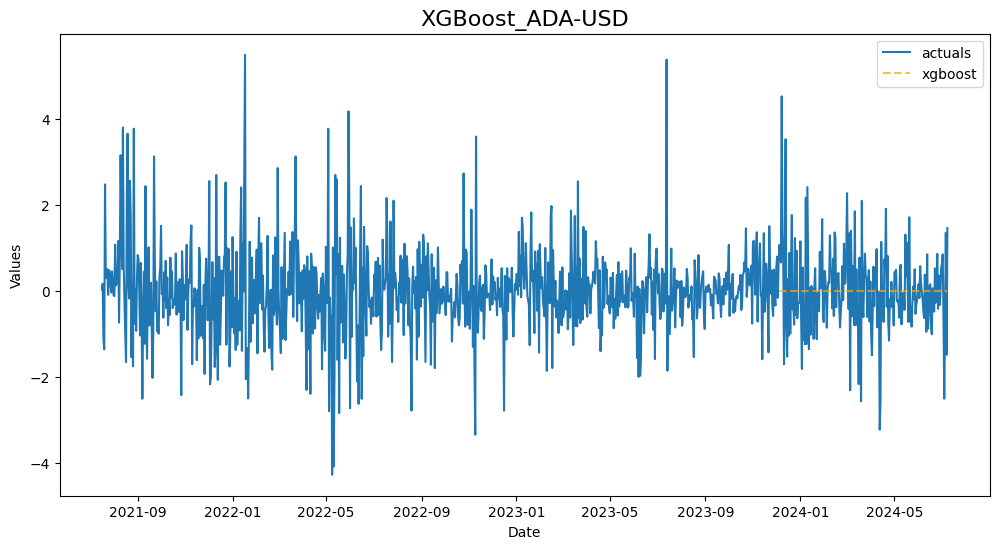

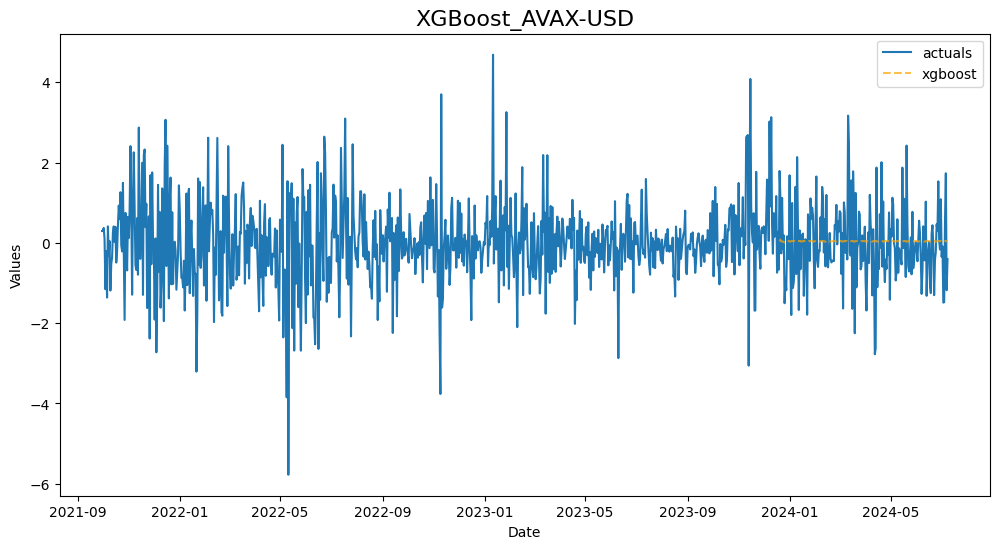

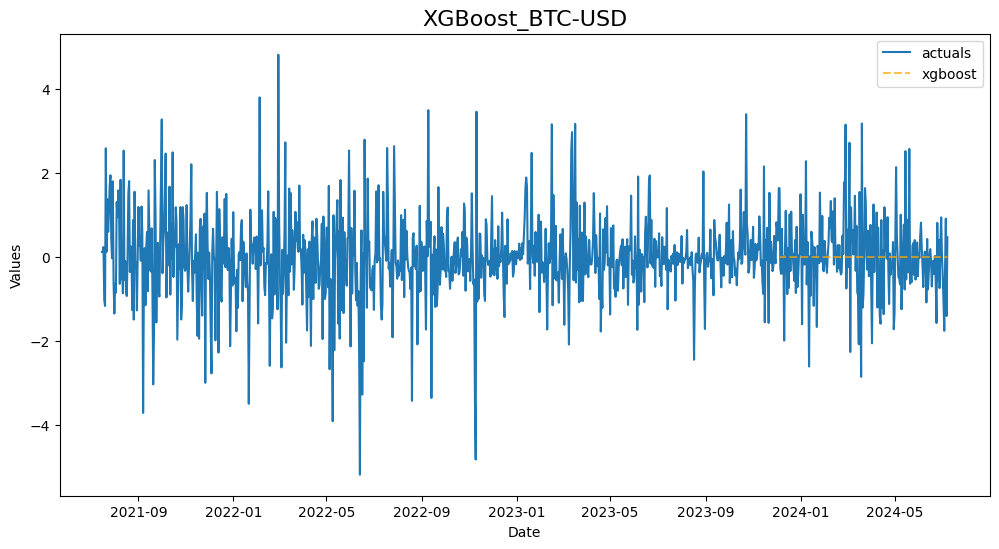

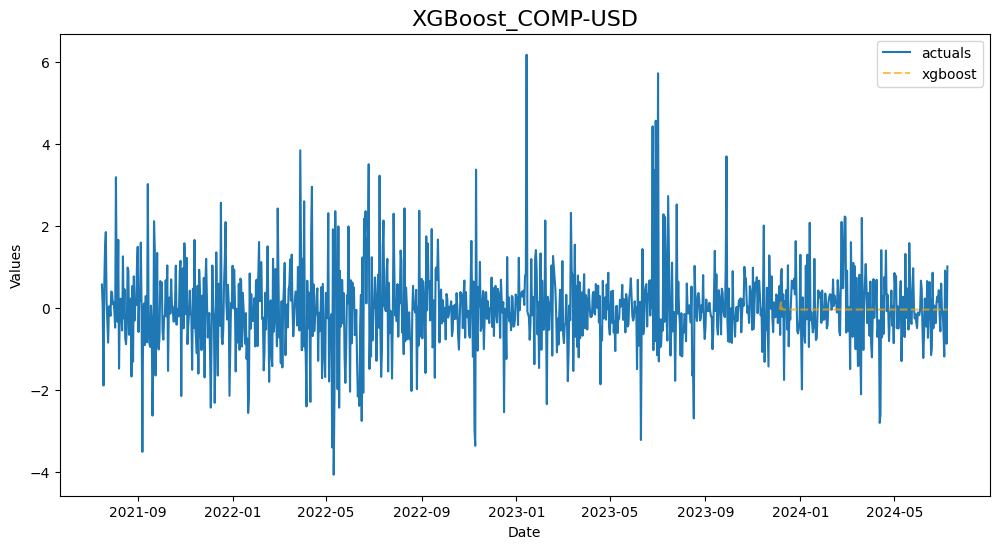

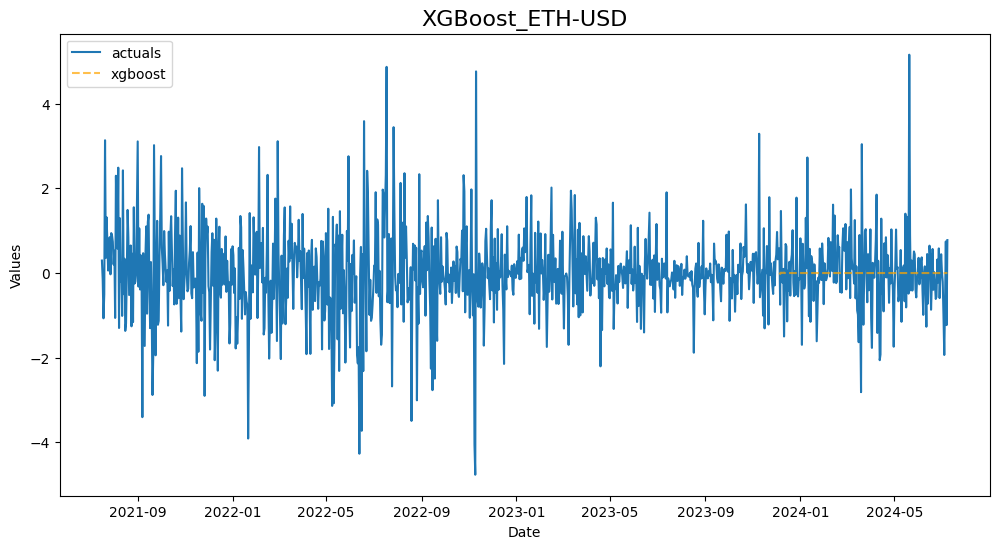

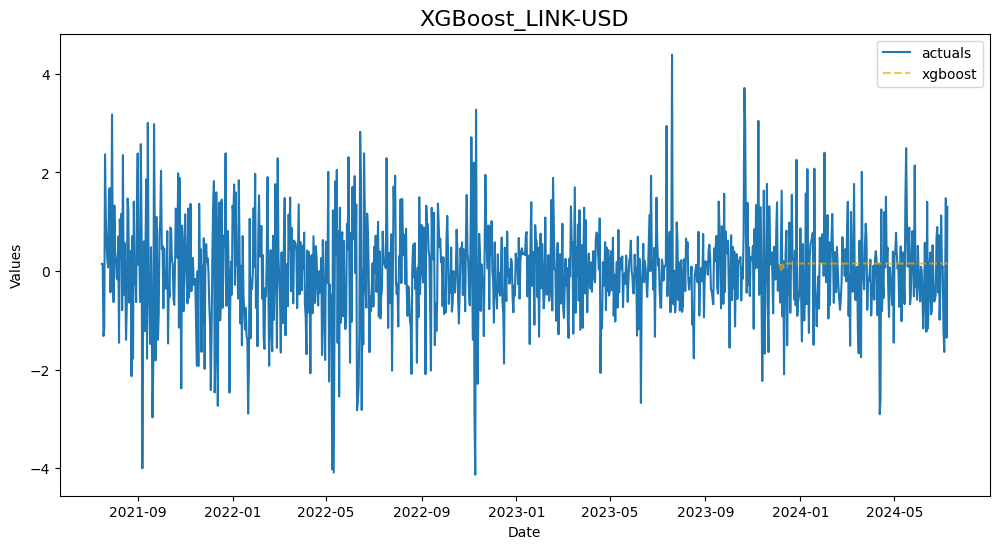

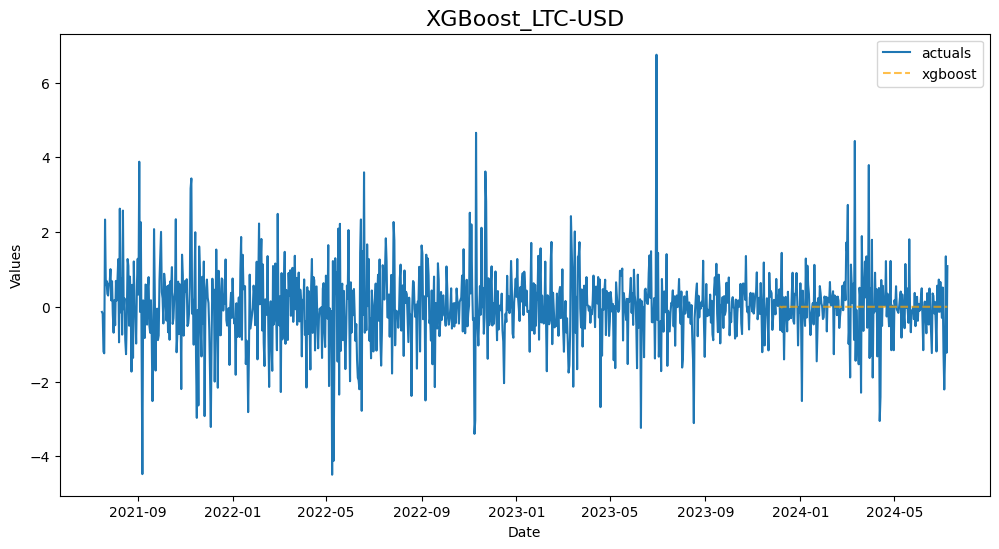

KeyboardInterrupt: 

In [79]:
x_column = [column for column in df.columns if column != 'pct_change' and column != "product_id"]
results_dict = {}
for product_id, group in df.groupby('product_id'):
    # Create a separate model for each product ID
    #future_dates = pd.date_range(start='2024-07-12', periods=7).strftime('%Y-%m-%d').tolist()
     # Perform seasonal decomposition
      # Perform seasonal decomposition
    # decomposition = seasonal_decompose(group['pct_change'], model='additive', period=365)
    # group['trend'] = decomposition.trend
    # group['seasonal'] = decomposition.seasonal
    # group['residual'] = decomposition.resid

    # # Fill NaN values in trend and seasonal components (common to do for initial missing values)
    # group['trend'].fillna(method='bfill', inplace=True)
    # group['seasonal'].fillna(method='bfill', inplace=True)
    # group['residual'].fillna(method='bfill', inplace=True)

    # group['year'] = group.index.year
    # group['month'] = group.index.month
    # Add new decomposed components to x_column
    # x_column_extended = x_column + ['trend', 'seasonal', 'residual','trend', 'seasonal', 'residual', 'year', 'month']
    f = Forecaster(
        y=group['pct_change'],  # Target variable
        X=group[x_column],  # Exogenous variables
        current_dates=group.index.strftime('%Y-%m-%d').tolist(),  # Date index
        future_dates=None,
        test_length=0,
        validation_length=None,
        cis=False,
        
    )
    transformer = SeriesTransformer(f)
    f = transformer.ScaleTransform()
    f.set_test_length(.2)
    f.set_last_future_date('2024-07-18') 
    f.add_ar_terms(7)
    f.add_seasonal_regressors('day_of_week')
    # Use day of week as a seasonal regressor
    f.add_time_trend()
    f.set_estimator('xgboost')   # Use XGBoost instead of LSTM

    xgboost_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [.001, .01, .1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
 }
    
    f.ingest_grid(xgboost_grid)
    f.cross_validate(k=3)
    f.auto_forecast()
    f.set_metrics(['mape', 'mse', 'rmse', 'mae'])
    f.export(
      to_excel = True,
      determine_best_by = 'TestSetMAPE',
      excel_name = f'forecast_metrics/XGBoost/XGBoost_Model_{product_id}.xlsx'
  )
    # Evaluate the model
    f.plot_test_set(order_by='TestSetMAPE', models=['xgboost'], ci=True)
    # plot_test_export_summaries(f)
    plt.title(f'XGBoost_{product_id}', size=16)
    plt.show()
    
    # # Store the results in the dictionary
    # results_dict[product_id] = {
    #     'forecast': f.generate_future_dates(7),
    #     'evaluation': f.get_metrics(),
    #     'models': f.models
    # }

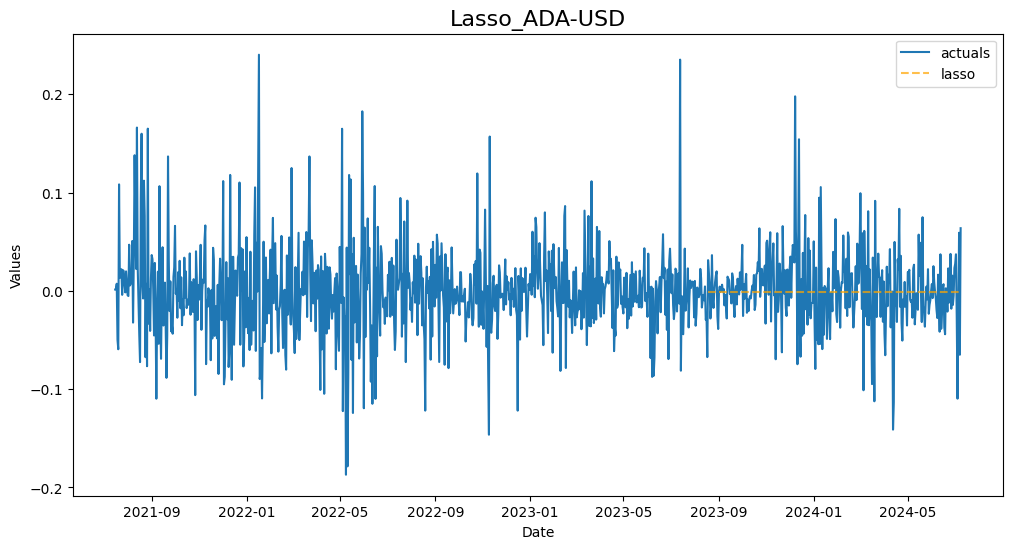

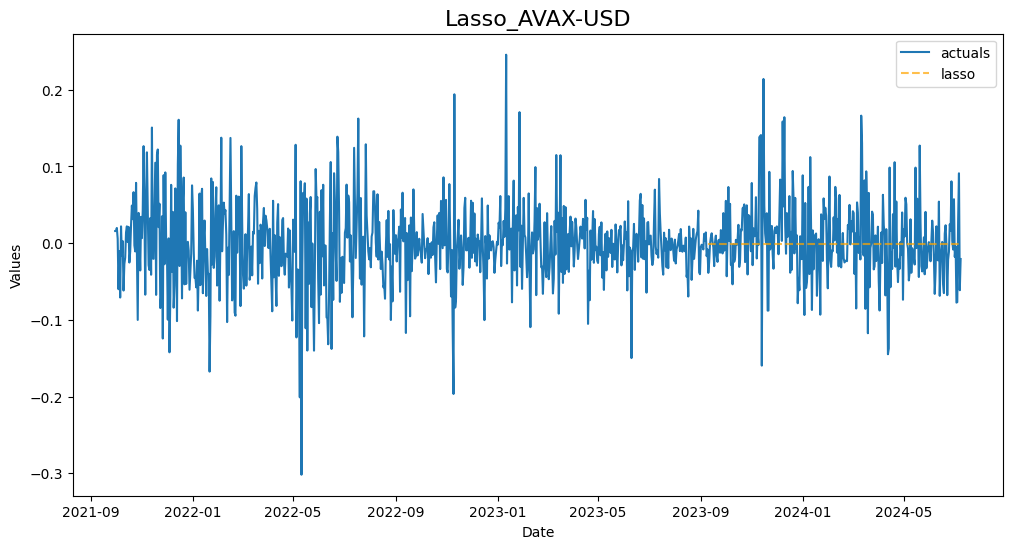

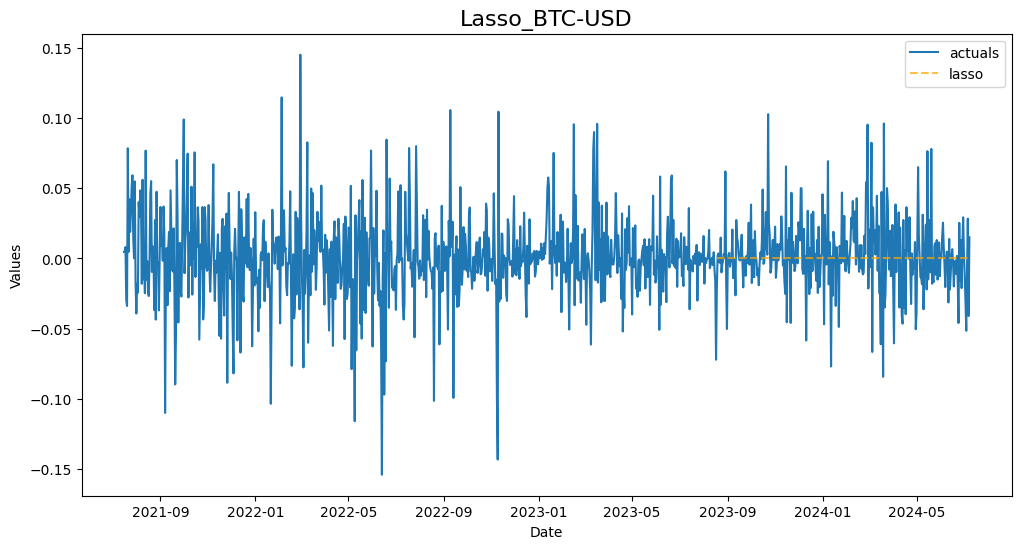

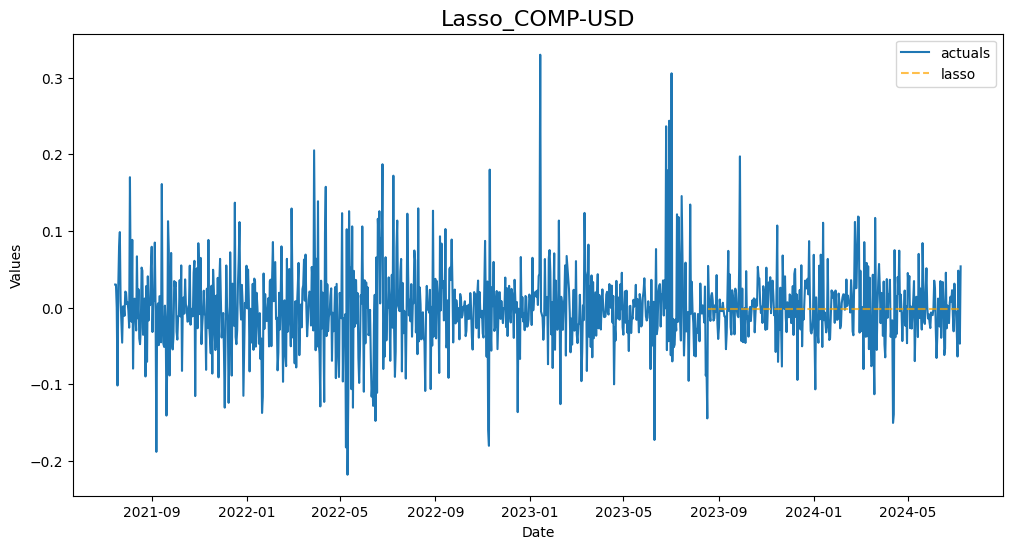

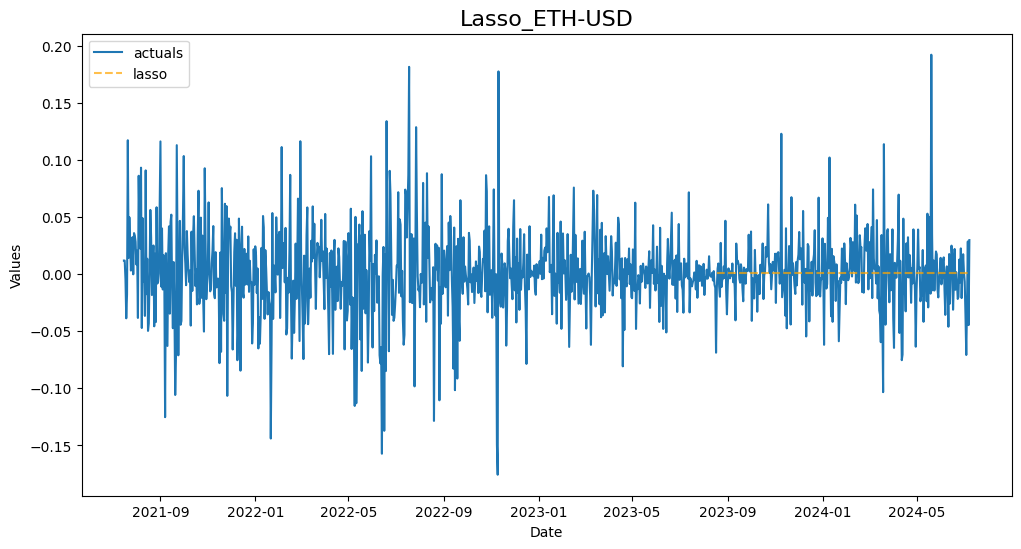

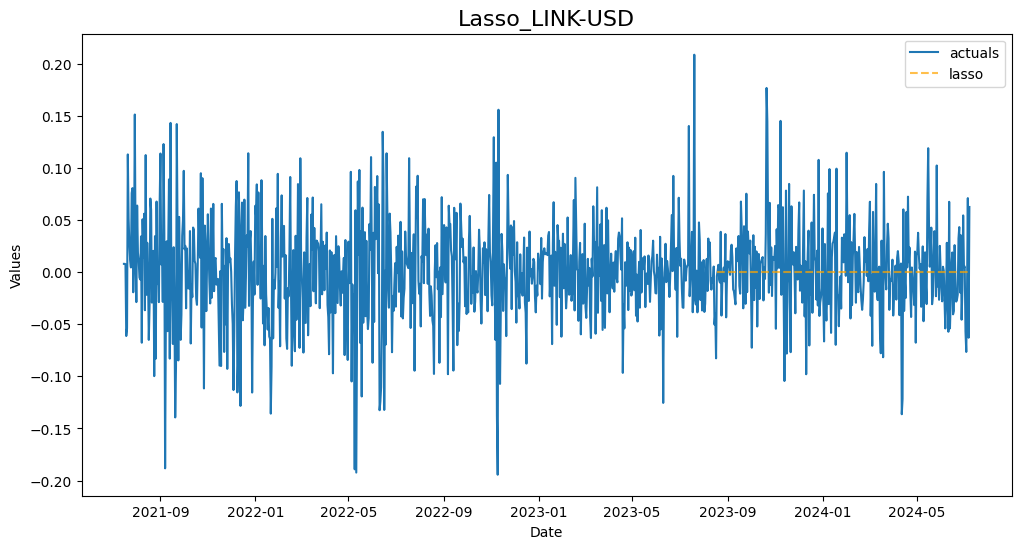

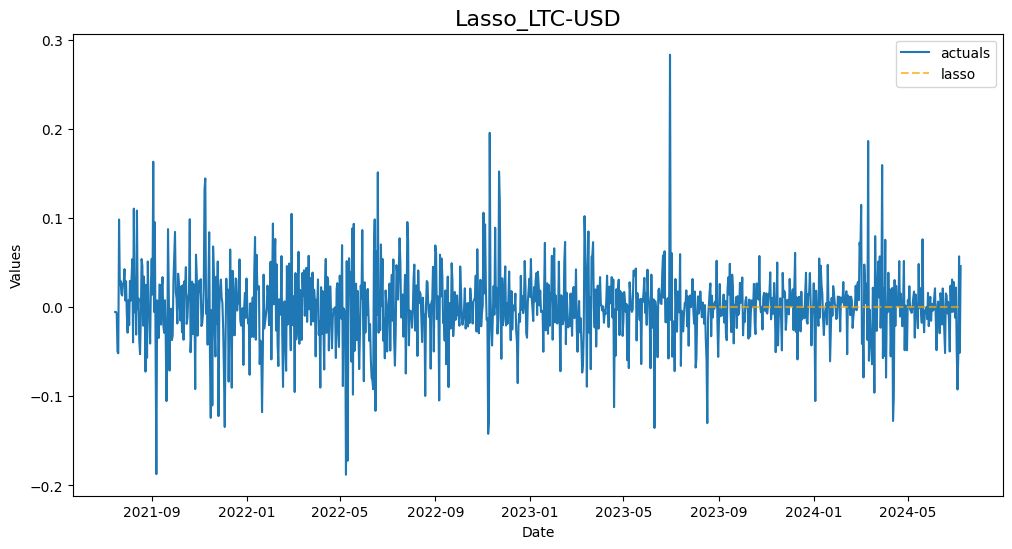

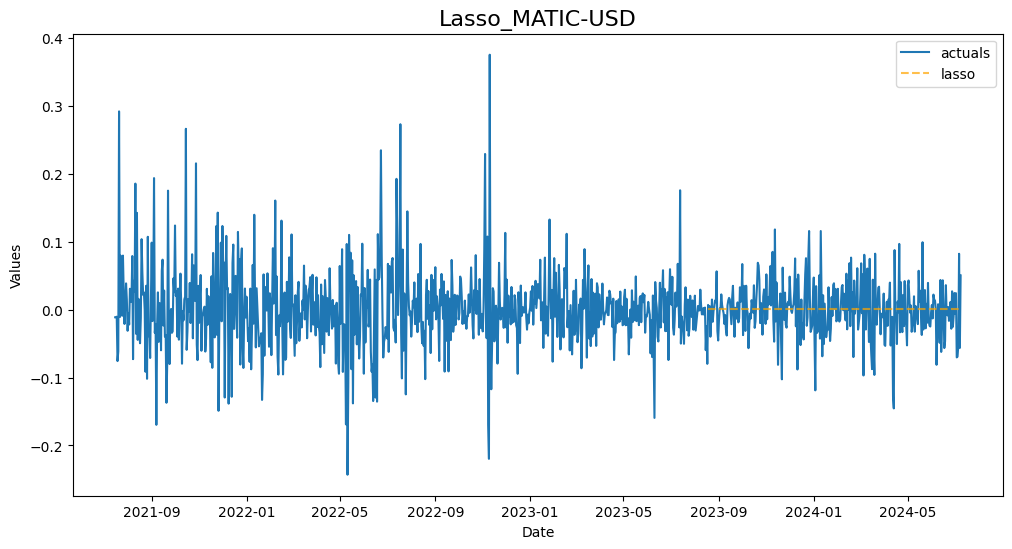

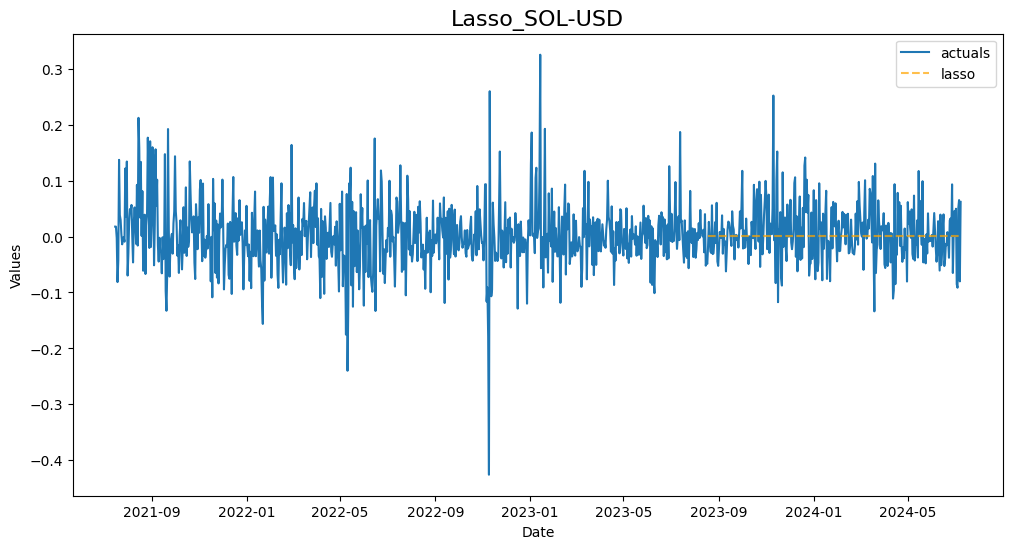

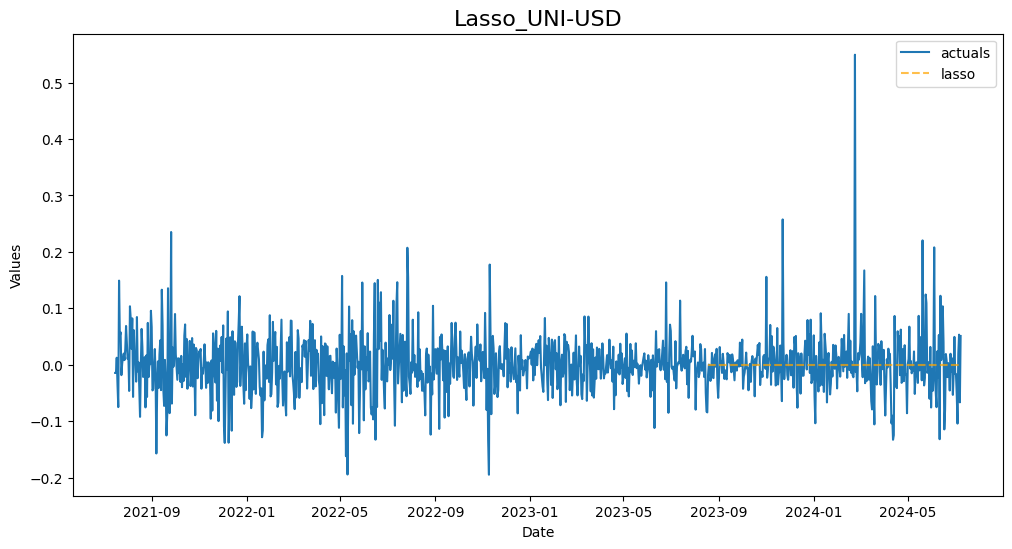

In [50]:
x_column = [column for column in df.columns if column != 'pct_change' and column != "product_id"]
results_dict = {}
for product_id, group in df.groupby('product_id'):
     # Perform seasonal decomposition
    decomposition = seasonal_decompose(group['pct_change'], model='additive', period=365)
    group['trend'] = decomposition.trend
    group['seasonal'] = decomposition.seasonal
    group['residual'] = decomposition.resid

    # Fill NaN values in trend and seasonal components (common to do for initial missing values)
    group['trend'].fillna(method='bfill', inplace=True)
    group['seasonal'].fillna(method='bfill', inplace=True)
    group['residual'].fillna(method='bfill', inplace=True)

    group['year'] = group.index.year
    group['month'] = group.index.month
    # Add new decomposed components to x_column
    x_column_extended = x_column + ['trend', 'seasonal', 'residual','trend', 'seasonal', 'residual', 'year', 'month']

    f = Forecaster(
        y=group['pct_change'],  # Target variable
        X=group[x_column],  # Exogenous variables
        current_dates=group.index.strftime('%Y-%m-%d').tolist(),  # Date index
        future_dates=None,
        test_length=0,
        validation_length=None,
        cis=False,
        
    )
    f.set_test_length(.3)
    f.set_last_future_date('2024-07-18') 
    f.add_ar_terms(1)
    # Add seasonal regressors
    f.add_seasonal_regressors('day_of_week')
    f.add_seasonal_regressors('month')
    f.add_seasonal_regressors('year')  # Use day of week as a seasonal regressor
    f.add_time_trend()
    f.set_estimator('lasso')
    lasso_grid = {'alpha':np.linspace(0,2,100)}
    f.ingest_grid(lasso_grid)
    f.cross_validate(k=3)
    f.auto_forecast()   

    #f.manual_forecast()
    f.set_metrics(['mape', 'mse', 'rmse', 'mae'])
    f.export(
      to_excel = True,
      determine_best_by = 'TestSetMAPE',
      excel_name = f'forecast_metrics/Lasso/Lasso_Model_{product_id}.xlsx'
  )
    # Evaluate the model
    f.plot_test_set(order_by='TestSetMAPE', models=['lasso', 'xgboost'], ci=True)
    # plot_test_export_summaries(f)
    plt.title(f'Lasso_{product_id}', size=16)
    plt.show()

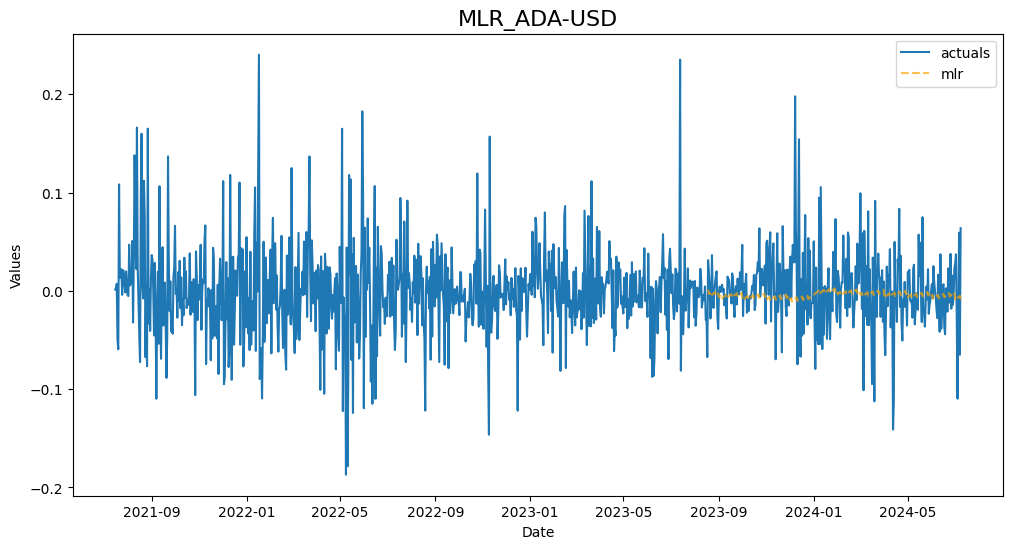

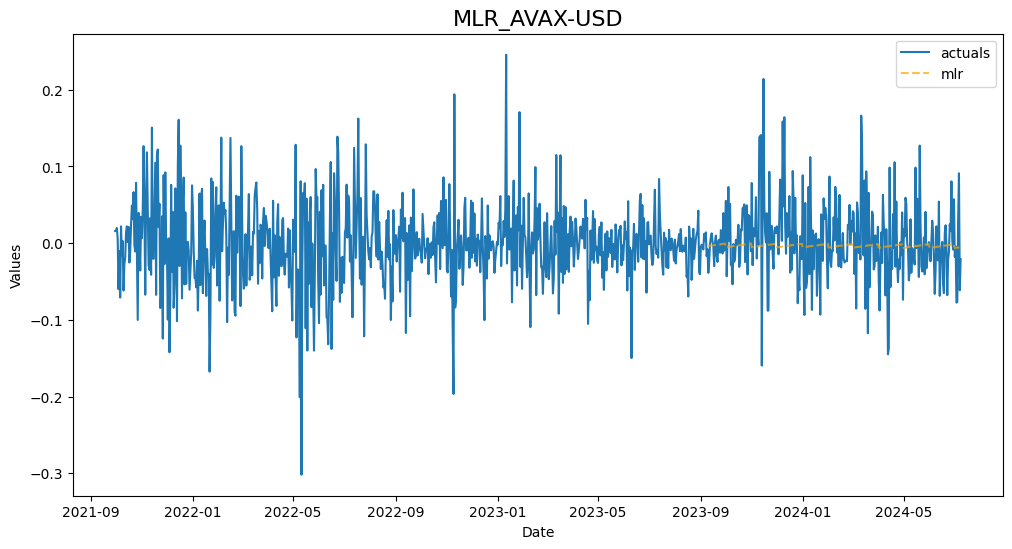

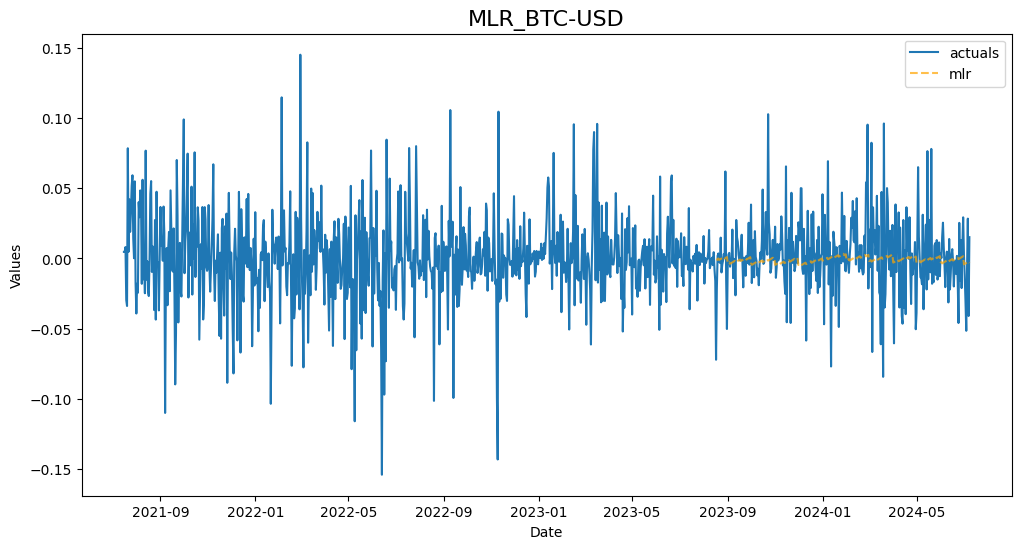

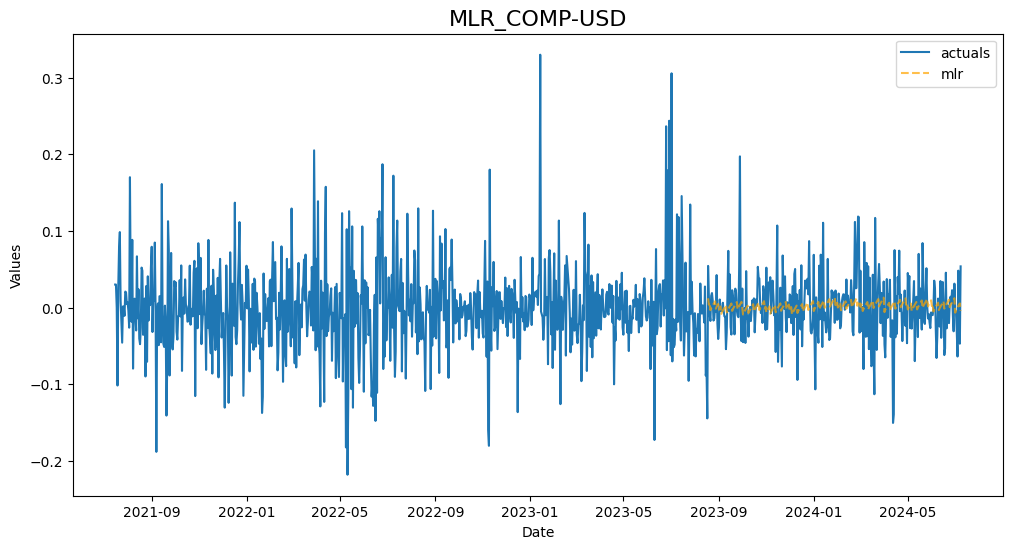

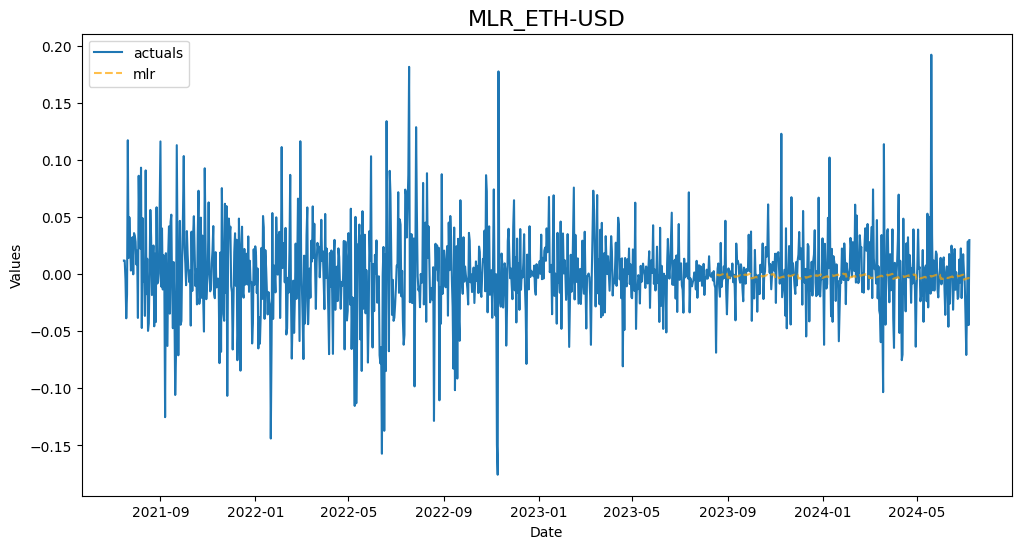

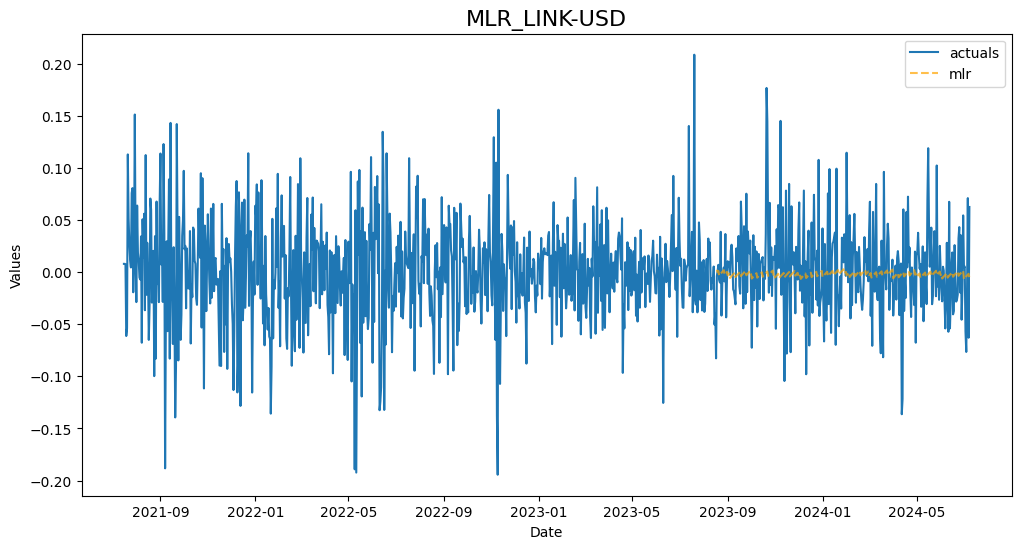

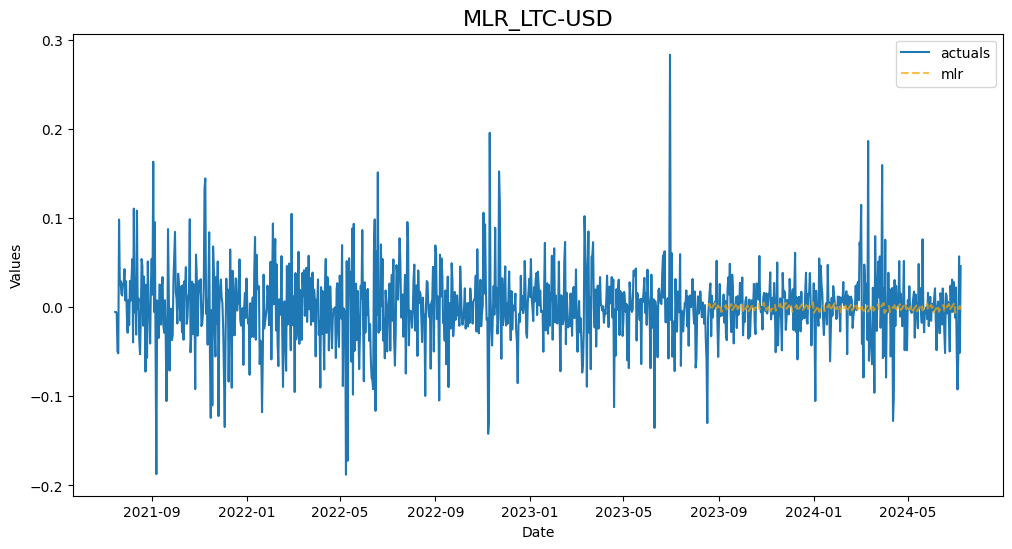

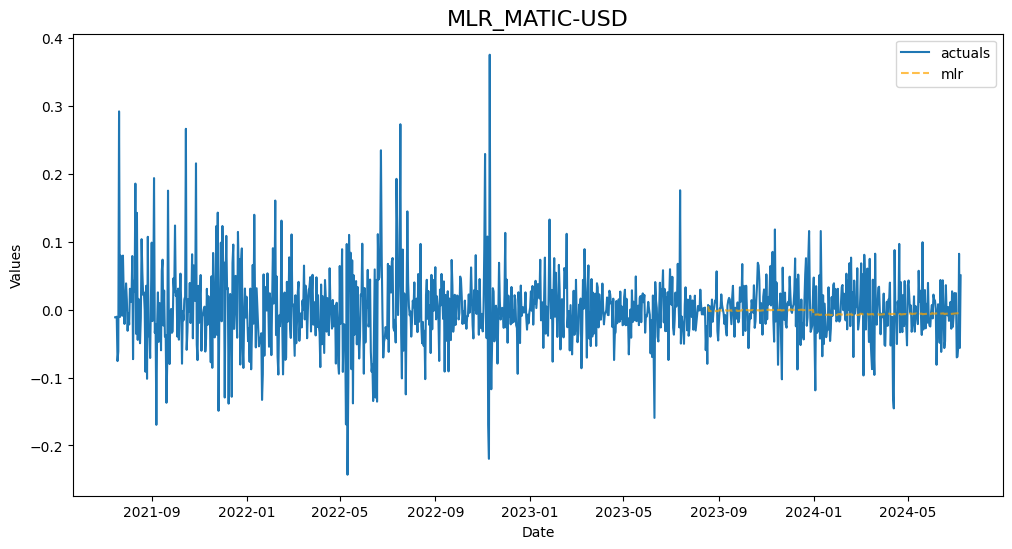

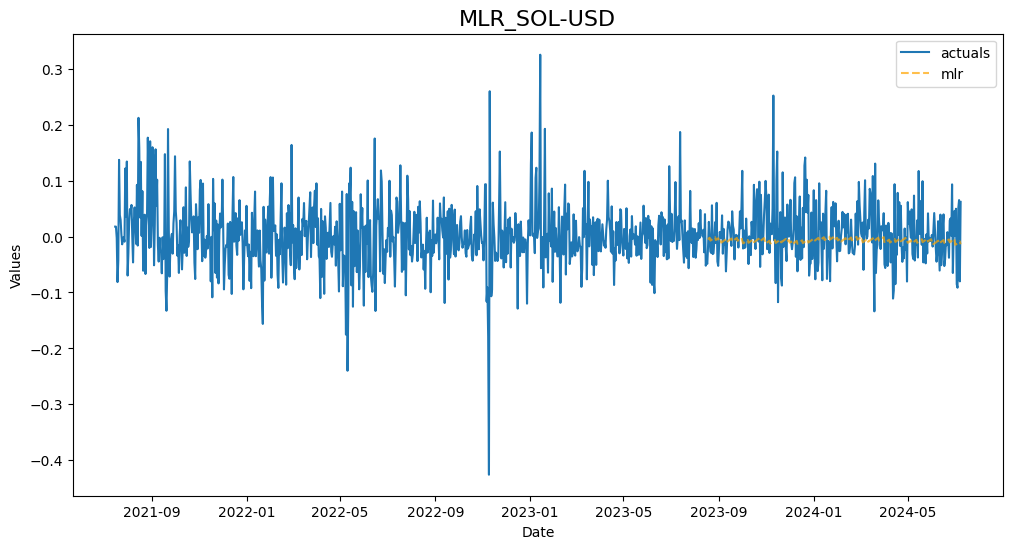

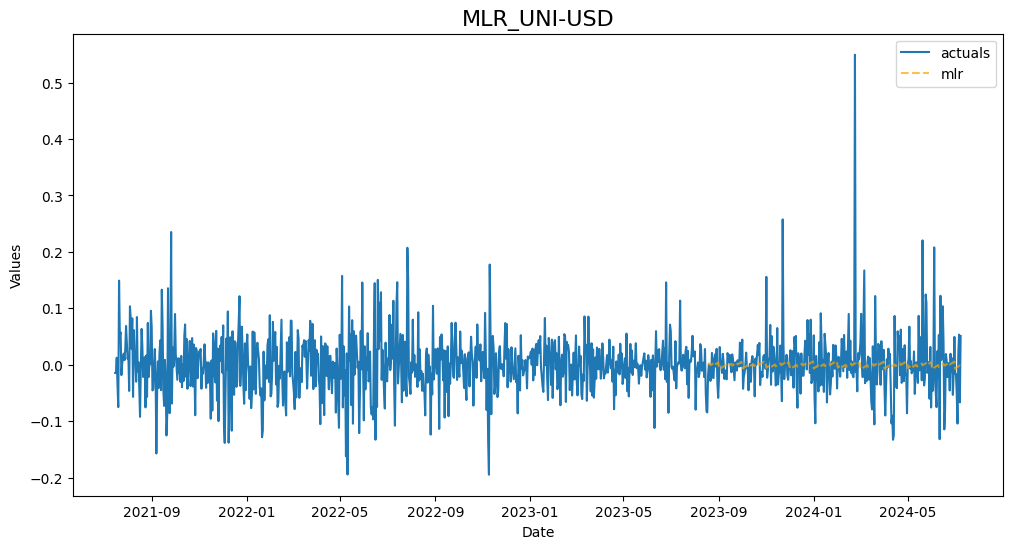

In [51]:
x_column = [column for column in df.columns if column != 'pct_change' and column != "product_id"]
results_dict = {}
for product_id, group in df.groupby('product_id'):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(group['pct_change'], model='additive', period=365)
    group['trend'] = decomposition.trend
    group['seasonal'] = decomposition.seasonal
    group['residual'] = decomposition.resid

    # Fill NaN values in trend and seasonal components (common to do for initial missing values)
    group['trend'].fillna(method='bfill', inplace=True)
    group['seasonal'].fillna(method='bfill', inplace=True)
    group['residual'].fillna(method='bfill', inplace=True)

    group['year'] = group.index.year
    group['month'] = group.index.month
    # Add new decomposed components to x_column
    x_column_extended = x_column + ['trend', 'seasonal', 'residual','trend', 'seasonal', 'residual', 'year', 'month']
    f = Forecaster(
        y=group['pct_change'],  # Target variable
        X=group[x_column],  # Exogenous variables
        current_dates=group.index.strftime('%Y-%m-%d').tolist(),  # Date index
        future_dates=None,
        test_length=0,
        validation_length=None,
        cis=False,
        
    )
    f.set_test_length(.3)
    f.set_last_future_date('2024-07-18') 
    f.add_ar_terms(1)
    f.add_seasonal_regressors('day_of_week')
    f.add_seasonal_regressors('month')
    f.add_seasonal_regressors('year')   # Use day of week as a seasonal regressor
    f.add_time_trend()
    f.set_estimator('mlr')   

    f.manual_forecast()
    f.set_metrics(['mape', 'mse', 'rmse', 'mae'])
    f.export(
      to_excel = True,
      determine_best_by = 'TestSetMAPE',
      excel_name = f'forecast_metrics/MLR/MLR_Model_{product_id}.xlsx'
  )
    # Evaluate the model
    f.plot_test_set(order_by='TestSetMAPE', models=['mlr', 'xgboost'], ci=True)
    # plot_test_export_summaries(f)
    plt.title(f'MLR_{product_id}', size=16)
    plt.show()

In [13]:
# x_columns = [
#      'day_of_week', 'volume_lag_1', 'volume_lag_3', 'volume_lag_7',
#      'RSI', 'MACD', 'volatility_7d', 'volatility_30d', 'momentum_7d',  'pct_change_lag_1', 'pct_change_lag_3', 'pct_change_lag_7'
# ]
# results_dict = {}
# for product_id, group in df.groupby('product_id'):
#     # Create a separate model for each product ID
#     #future_dates = pd.date_range(start='2024-07-12', periods=7).strftime('%Y-%m-%d').tolist()
#     f = Forecaster(
#         y=group['pct_change'],  # Target variable
#         X=group[x_columns],  # Exogenous variables
#         current_dates=group.index.strftime('%Y-%m-%d').tolist(),  # Date index
#         future_dates=None,
#         test_length=0,
#         validation_length=None,
#         cis=False,
        
#     )
#     f.set_test_length(.2)
#     f.set_last_future_date('2024-07-18') 
#     f.add_ar_terms(3)
#     f.add_seasonal_regressors('day_of_week', dummy=True)  # Use day of week as a seasonal regressor
#     f.add_time_trend()
#     f.set_estimator('lstm')   # Use LSTM instead of XGBoost

#     f.manual_forecast(
#     layers_struct=[
#         ('LSTM',{'units':128,'dropout':0.2})
#     ] * 3 + [
#         ('Dense',{'units':10})
#     ] * 1,
#     epochs=100,
#     random_seed=42,
#     plot_loss=True,
#     validation_split=0.2,
#     call_me='lstm_3layer',
#     verbose=0
# )
#     f.auto_forecast()
#     f.set_metrics(['mape', 'mse', 'rmse', 'mae'])
#     f.export(
#       to_excel = True,
#       determine_best_by = 'TestSetMAPE',
#       excel_name = f'forecast_metrics/LSTM/LSTM_Model_{product_id}.xlsx'
#   )
#     # Evaluate the model
#     f.plot_test_set(order_by='TestSetMAPE', models=['lstm'], ci=True)
#     # plot_test_export_summaries(f)
#     plt.title(f'LSTM_{product_id}', size=16)
#     plt.show()

In [68]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Group by product_id
# for product_id, group in df.groupby('product_id'):
#     print(f"Analyzing product_id: {product_id}")
    
#     # Ensure the group is sorted by date
#     group = group.sort_index()

#     # Plot ACF and PACF for non-seasonal lags
#     fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#     plot_acf(group['pct_change'].dropna(), lags=40, ax=ax[0])
#     plot_pacf(group['pct_change'].dropna(), lags=40, ax=ax[1])
#     plt.suptitle(f'ACF and PACF for product_id: {product_id}')
#     plt.show()

#     # Seasonal decomposition to determine the seasonal period (Yearly)
#     result = seasonal_decompose(group['pct_change'].dropna(), model='additive', period=365)
#     result.plot()
#     plt.suptitle(f'Seasonal Decomposition (Yearly) for product_id: {product_id}')
#     plt.show()

#     # Seasonal decomposition to determine the seasonal period (Weekly)
#     result = seasonal_decompose(group['pct_change'].dropna(), model='additive', period=7)
#     result.plot()
#     plt.suptitle(f'Seasonal Decomposition (Weekly) for product_id: {product_id}')
#     plt.show()


In [80]:
# Specify the Excel file path
file_path = '/Users/justinfarnan_hakkoda/capstone_project/Capstone_Project/forecast_metrics/XGBoost/XGBoost_Model_ADA-USD.xlsx'
mlr_file_path = 'forecast_metrics/MLR/MLR_Model_ADA-USD.xlsx'

# Get the list of sheet names
sheet_names = pd.ExcelFile(file_path).sheet_names

# Create a dictionary to store the data for each sheet
data_dict = {}

# Loop through each sheet and read in the data
for sheet_name in sheet_names:
    ada_metircs = pd.read_excel(file_path, sheet_name=sheet_name)
    data_dict[sheet_name] = ada_metircs

# Now you can access the data for each sheet using the sheet name as the key
for sheet_name, ada_metircs in data_dict.items():
    print(f"Sheet Name: {sheet_name}")




Sheet Name: model_summaries
Sheet Name: lvl_fcsts
Sheet Name: lvl_test_set_predictions


In [44]:
mlr_sums = pd.read_excel(mlr_file_path, sheet_name='model_summaries')
mlr_sums

,ModelNickname,Estimator,Xvars,HyperParams,Observations,DynamicallyTested,TestSetLength,CILevel,ValidationMetric,ValidationMetricValue,...,weights,best_model,InSampleRMSE,InSampleMAPE,InSampleMAE,InSampleR2,TestSetRMSE,TestSetMAPE,TestSetMAE,TestSetR2
0,mlr,mlr,"['AR1', 'day_of_week', 'day_of_week_0', 'day_o...",{},1084,True,325,NaN,NaN,NaN,...,NaN,True,0.043581,NaN,0.03074,0.007234,0.038172,NaN,0.027281,-0.032799


In [81]:
model_sums = pd.read_excel(file_path, sheet_name='lvl_test_set_predictions')
model_sums

,DATE,actual,xgboost
0,2023-12-05,1.070560,-0.009455
1,2023-12-06,0.920893,-0.009455
2,2023-12-07,0.663474,-0.009455
3,2023-12-08,4.528137,-0.009455
4,2023-12-09,1.397366,-0.009455
...,...,...,...
211,2024-07-04,-2.505100,-0.009455
212,2024-07-05,-0.755156,-0.009455
213,2024-07-06,1.354902,-0.009455
214,2024-07-07,-1.483635,-0.009455


In [82]:
ada_forecasts = pd.read_excel(file_path, sheet_name='lvl_fcsts')
ada_forecasts

,DATE,xgboost
0,2024-07-09,-0.006803
1,2024-07-10,0.001550
2,2024-07-11,-0.006803
3,2024-07-12,0.001550
4,2024-07-13,-0.006803
5,2024-07-14,-0.006803
6,2024-07-15,-0.006803
7,2024-07-16,-0.006803
8,2024-07-17,-0.006803
9,2024-07-18,-0.006803


In [83]:
ada_metrics = pd.read_excel(file_path, sheet_name='model_summaries')
for params in ada_metrics['HyperParams']:
    print(params)

{'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.001, 'subsample': 1.0, 'colsample_bytree': 1.0}


In [84]:
test_df = pd.read_csv('RAW_Data/test_weekago_updt_717.csv')
test_df['pct_change'] = test_df.groupby('product_id')['close'].pct_change()

In [39]:
test_df.sort_values('time', inplace = True)

In [40]:
test_df = test_df.rename(columns = {'time': 'DATE'})

In [41]:
test_df['DATE'] = pd.to_datetime(test_df['DATE'])

In [42]:
ada_test = test_df[test_df['product_id'] == 'ADA-USD']
ada_test

,Unnamed: 0,DATE,low,high,open,close,volume,price_change,average_price,volatility,product_id,pct_change
27,27,2024-07-12,0.3932,0.4180,0.3962,0.4164,1.924438e+07,0.0202,0.40560,6.307223,ADA-USD,-0.057705
26,26,2024-07-13,0.4117,0.4471,0.4166,0.4419,2.012002e+07,0.0253,0.42940,8.598494,ADA-USD,0.023390
25,25,2024-07-14,0.4239,0.4453,0.4419,0.4318,1.315974e+07,-0.0101,0.43460,5.048360,ADA-USD,-0.029881
24,24,2024-07-15,0.4312,0.4460,0.4318,0.4451,1.997885e+07,0.0133,0.43860,3.432282,ADA-USD,0.015746
23,23,2024-07-16,0.4266,0.4528,0.4452,0.4382,2.000276e+07,-0.0070,0.43970,6.141585,ADA-USD,0.004815
22,22,2024-07-17,0.4355,0.4568,0.4381,0.4361,1.876214e+07,-0.0020,0.44615,4.890930,ADA-USD,-0.006153
21,21,2024-07-18,0.4359,0.4434,0.4360,0.4388,1.064133e+06,0.0028,0.43965,1.720578,ADA-USD,NaN


In [24]:
print(ada_forecasts.columns)
print(ada_test.columns)

Index(['DATE', 'xgboost'], dtype='object')
Index(['Unnamed: 0', 'DATE', 'low', 'high', 'open', 'close', 'volume',
       'price_change', 'average_price', 'volatility', 'product_id',
       'pct_change'],
      dtype='object')


In [73]:
combine_df = pd.merge(ada_forecasts, ada_test[['product_id', 'pct_change', 'DATE']], on='DATE', how='inner')

In [74]:
combine_df.dropna(inplace = True)

In [75]:
combine_df

,DATE,xgboost,product_id,pct_change
0,2024-07-12,-0.202274,ADA-USD,-0.057705
1,2024-07-13,-0.140761,ADA-USD,0.023390
2,2024-07-14,-0.298580,ADA-USD,-0.029881
3,2024-07-15,-0.408455,ADA-USD,0.015746
4,2024-07-16,-0.459611,ADA-USD,0.004815
5,2024-07-17,-0.491403,ADA-USD,-0.006153


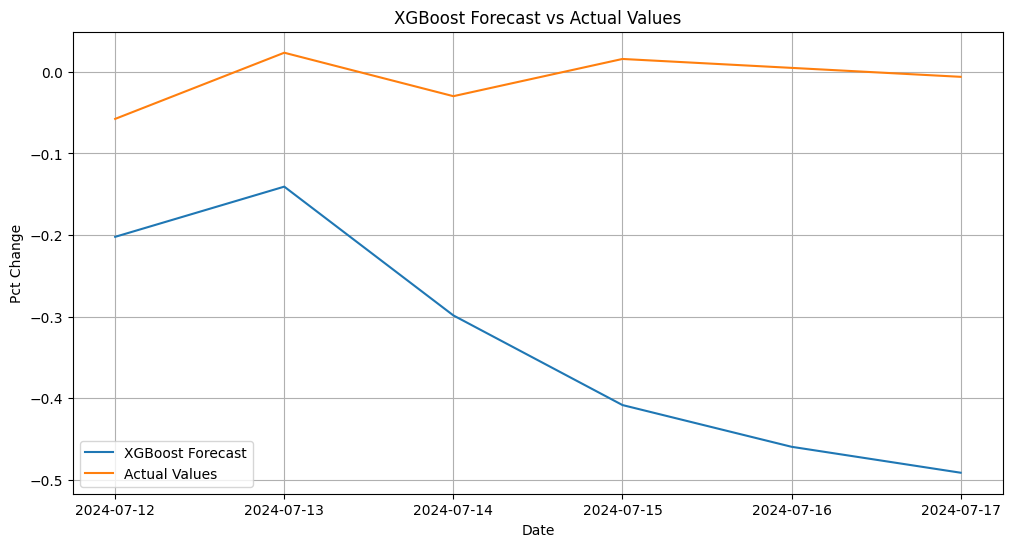

In [76]:
import matplotlib.pyplot as plt

# Assuming combine_df is the merged DataFrame
plt.figure(figsize=(12,6))
plt.plot(combine_df['DATE'], combine_df['xgboost'], label='XGBoost Forecast')
plt.plot(combine_df['DATE'], combine_df['pct_change'], label='Actual Values')

plt.xlabel('Date')
plt.ylabel('Pct Change')
plt.title('XGBoost Forecast vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()